In [4]:
using Interpolations

using PyCall

# Load the numerical LTE solver
push!(LOAD_PATH,"../../src/")
using LTE_solver
using dyn_LN_functions: get_LN2mq_analytical, get_LN2mq_numerical, get_Hres2mq_analytical

@pyimport seaborn as sns
@pyimport matplotlib as mpl


using HDF5
using PyPlot
PyPlot.isjulia_display[] = false;

#PyPlot.matplotlib[:rc]("font",family="Arial", weight="medium", style="normal")
PyPlot.matplotlib[:rc]("axes",titlesize=10.5, labelsize=10, unicode_minus=false)
PyPlot.matplotlib[:rc]("xtick",labelsize=9.5)
PyPlot.matplotlib[:rc]("ytick",labelsize=9.5)
PyPlot.matplotlib[:rc]("pdf",fonttype=42)
#PyPlot.matplotlib[:rc]("mathtext", fontset = "stix")

fig_width = 7

const METRE_TO_CM = 100
const GAL_TO_MGAL = 1000;

const newaxis = [CartesianIndex()];

┌ Info: Precompiling LTE_solver [top-level]
└ @ Base loading.jl:1317
┌ Info: Precompiling dyn_LN_functions [top-level]
└ @ Base loading.jl:1317


# Define useful functions

In [5]:
# Wrapper function to calculate dynamical Love numbers numerically or analytically
# - Calls either of the above two functions to calculate LN
# - Does not need LNt, LNp, ups or beta. These are calculated directly from 
#   interpolation functions that must already be defined when the function is called.
# - Automatically calculates the solution over many dimensions with list comprehension, 
#   meaning that you can avoid lots of nested for-loops.
#
# Inputs: m = harmonic order
#         R = Radius 
#         g = Surface gravity 
#         rot = Rotation rate 
#         hi = Ice thickness, in km
#         a = Ocean drag coefficient 
#         mu = Ice shear modulus, in GPa
#         ho = Ocean thickness 
#         freqs = Forcing Frequency/Rotation rate
#         visc = Ice viscosity
#         h2o_const = thickness of H2O layer, in km. If > 0, the ho input is ignored, and ocean
#                     thickness is instead directly calculated from h2o_const - hi. This 
#                     reduces the dimensions of the output Love number by 1, as hi and ho are 
#                     no longer independent. If h2o_const < 0 (default), the ho and hi are 
#                     treated independently.
#         numerical = Use numerical solution or approximate analytical solution
# Output: LN = Dynamic Love number
function get_LN(t, m, R, g, rot, hi, a, mu, ho, freqs, visc; h2o_const=-1, numerical=false) 
    function make_range(val) 
        if isempty(size(val))
            return val:1:val
        else 
            return val
        end
    end

    visc = make_range(visc)
    freqs = make_range(freqs)
    hi = make_range(hi)
    mu = make_range(mu)
    ho = make_range(ho)
    a = make_range(a)

    vs = length(visc)
    mus = length(mu)
    his = length(hi)
    fs = length(freqs)
    as = length(a)
    hos = length(ho)

    min_len = 6

    upss  = [ups_int(v, rig, h, abs(q), 2) for v in visc, h in hi, rig in mu, q in freqs]

    if t == 'h' 
        LNts   = [ht_int(v, rig, h, abs(q), 2) for v in visc, h in hi, rig in mu, q in freqs]
        LNps   = [hp_int(v, rig, h, abs(q), 2) for v in visc, h in hi, rig in mu, q in freqs];
    elseif t == 'k'
        LNts   = [kt_int(v, rig, h, abs(q), 2) for v in visc, h in hi, rig in mu, q in freqs]
        LNps   = [kp_int(v, rig, h, abs(q), 2) for v in visc, h in hi, rig in mu, q in freqs];
    end

    #    Use the analytical solver  
    if !numerical
        betas = [beta_int(v, rig, h, abs(q), 2) for v in visc, h in hi, rig in mu, q in freqs]

        for i in eachindex(freqs)
            if freqs[i] > 0
                betas[:, :, :, i] .= conj.(betas[:, :, :, i]) 
                upss[:, :, :, i]  .= conj.(upss[:, :, :, i]) 
                LNts[:, :, :, i]   .= conj.(LNts[:, :, :, i]  ) 
                LNps[:, :, :, i]   .= conj.(LNps[:, :, :, i]  )
            end
        end
    
        
        if h2o_const < 0
            # Reshape arrays for vectorized multiplication
            #                        alpha           h_ocean
            # extra dim for fluids:    |               |
            beta2 =reshape(betas, (vs, 1, his, mus, fs, 1))
            ups2 = reshape(upss, (vs, 1, his, mus, fs, 1))
            LNt2 = reshape(LNts, (vs, 1, his, mus, fs, 1))
            LNp2 = reshape(LNps, (vs, 1, his, mus, fs, 1))
            

            freqs2 = reshape(freqs,(1, 1,   1,   1, fs, 1))
            a2 = reshape(a,        (1,as,   1,   1,  1, 1))
            hi2 = reshape(hi,      (1, 1, his,   1,  1, 1))
            ho2 = reshape(ho,      (1, 1,   1,   1,  1, hos))

            LN = get_LN2mq_analytical(m, R, g, rot, freqs2.*rot, ho2.*1e3, a2, LNt2, LNp2, ups2, beta2 ) 

        else
            min_len -= 1

            beta2 = reshape(betas, (vs, 1, his, mus, fs))
            ups2 = reshape(upss, (vs, 1, his, mus, fs))
            LNt2 = reshape(LNts, (vs, 1, his, mus, fs))
            LNp2 = reshape(LNps, (vs, 1, his, mus, fs))
            freqs2 = reshape(freqs,(1, 1,   1,   1, fs))
            a2 = reshape(a,        (1,as,   1,   1,  1))
            hi2 = reshape(hi,      (1, 1, his,   1,  1))


            LN = get_LN2mq_analytical(m, R, g, rot, freqs2.*rot, (h2o_const .- hi2).*1e3, a2, LNt2, LNp2, ups2, beta2 ) 
        end

    else
        betas = [beta_int(v, rig, h, abs(q), n) for v in visc, h in hi, rig in mu, q in freqs, n in 1:1:8]

        for i in eachindex(freqs)
            if freqs[i] > 0
                betas[:, :, :, i, :] .= conj.(betas[:, :, :, i, :]) 
                upss[:, :, :, i]  .= conj.(upss[:, :, :, i]) 
                LNts[:, :, :, i]   .= conj.(LNts[:, :, :, i]  ) 
                LNps[:, :, :, i]   .= conj.(LNps[:, :, :, i]  )
            end
        end

        if h2o_const < 0
            LN = [get_LN2mq_numerical(m, R, g, rot, freqs[y]*rot, ho[z]*1e3, a[j], 
                    LNts[i, k, x, y], LNps[i, k, x, y], upss[i, k, x, y], betas[i, k, x, y, :])
                    for i in 1:vs, j in 1:as, k in 1:his, x in 1:mus, y in 1:fs, z in 1:hos]
        else
            min_len -= 1
            LN = [get_LN2mq_numerical(m, R, g, rot, freqs[y]*rot, (h2o_const - hi[k])*1e3, a[j], 
                    LNts[i, k, x, y], LNps[i, k, x, y], upss[i, k, x, y], betas[i, k, x, y, :])
                    for i in 1:vs, j in 1:as, k in 1:his, x in 1:mus, y in 1:fs]
        end
        
        
    end

    # Drop unwanted (length 1) dimensions, unless every dimension is length 1
    if size(LN) != Tuple([1 for i in 1:min_len])
        LN = dropdims(LN, dims = (findall(size(LN) .== 1)...,))
        return LN
    else
        return LN[1]
    end
end

# Wrapper function to calculate resonant ocean thickness
# Inputs: m = harmonic order
#         R = Radius 
#         g = Surface gravity 
#         rot = Rotation rate 
#         hi = Ice thickness, in km
#         mu = Ice shear modulus, in GPa
#         freqs = Forcing Frequency/Rotation rate
#         visc = Ice viscosity
#         numerical = Use numerical solution or approximate analytical solution
# Output: Hres = Resonant ocean thickness
function get_Hres(m, R, g, rot, hi, mu, freqs, visc; numerical=false)
    if !numerical
        beta = beta_int(visc, mu, hi, abs(freqs), 2)

        if freqs > 0
            beta = conj(beta) 
        end

        Hres = get_Hres2mq_analytical( m, R, g, rot, freqs*rot, beta)

    end
    return Hres
end

get_Hres (generic function with 1 method)

## Create interpolator object to retrieve pre-computed static Love numbers

In [6]:
# Load precomputed static love number data, calculated using LNTools (Kamata et al., 2015).
dataFile = h5open("./data/static_ln_europa_all.h5", "r")

# read Love number data
beta_data = read(dataFile["beta"])
ups_data  = read(dataFile["upsilon"])
hp_data  = read(dataFile["hp"])[:, :, :, :, 1, :] # h pressure Love number at surface 
ht_data  = read(dataFile["ht"])[:, :, :, :, 1, :] # h tidal Love number at surface
kp_data  = read(dataFile["kp"])[:, :, :, :, 1, :] # k pressure Love number at surface
kt_data  = read(dataFile["kt"])[:, :, :, :, 1, :] # k tidal Love number at surface
# Note, Love numbers at the ocean surface and bottom can be retrieved with 2 and 3


# read dimensions of data
h_ice_data = read(dataFile["ice thickness"])
visc_ice_data = vec(read(dataFile["ice viscosity"]) )
rig_ice_data = read(dataFile["ice rigidity"])
freqs_data = read(dataFile["frequencies"])
nmax = read(dataFile["nmax"])

close(dataFile)

indx = (visc_ice_data, rig_ice_data, h_ice_data, freqs_data, 1:1:nmax)

# Create linear interpolation object
beta_int = LinearInterpolation( indx, beta_data, extrapolation_bc=Line() );
ups_int  = LinearInterpolation( indx, ups_data, extrapolation_bc=Line() );
hp_int   = LinearInterpolation( indx, hp_data, extrapolation_bc=Line() );
ht_int   = LinearInterpolation( indx, ht_data, extrapolation_bc=Line() );
kp_int   = LinearInterpolation( indx, kp_data, extrapolation_bc=Line() );
kt_int   = LinearInterpolation( indx, kt_data, extrapolation_bc=Line() );

As an example, Beta at visc=10^14 Pa s, shear modulus=3.5 GPa, h_ice=23 km, frequency q=5, and degree n=2, can be retrieved with:

In [7]:

β = beta_int(14, 3.5, 23, 5, 2)

0.8661560263220114 + 0.017651181439231257im

## Define moon constants

In [8]:
# Constants for Europa
R_e = 1550e3       # Radius
g_e = 1.3          # Gravity
rot_e = 2.05e-5    # Rotation rate

H_H2O_e = 150e3;    # H2O layer thickness

# Figure 2

## Define parameter range

In [9]:
N = 201   # Number of solutions

q1 = 1    # Frequency 1 to plot
q2 = 10   # Frequency 2 to plot

H_ice = 10 # km
alpha = 1e-6;       # Ocean drag coefficient

## Define solution arrays

In [10]:
h22_num   = zeros(ComplexF64, (N));
h22_analy = zeros(ComplexF64, (N));
h2_static = zeros(ComplexF64, (N));

## Define figure

In [11]:
fig = plt.figure(constrained_layout=false, figsize=[fig_width,2.8])
gs1 = fig.add_gridspec(nrows=2, ncols=2, hspace=0.08, wspace=0.2, height_ratios=[2.9,1])

ax1 = fig.add_subplot(gs1[1, 1])
ax3 = fig.add_subplot(gs1[2, 1])

ax2 = fig.add_subplot(gs1[1, 2])
ax4 = fig.add_subplot(gs1[2, 2])

c1 = [0.4, 0.7607843137254902, 0.6470588235294118]
c2 = [0.9882352941176471, 0.5529411764705883, 0.3843137254901961];

## Calculate Love number solutions and how-to

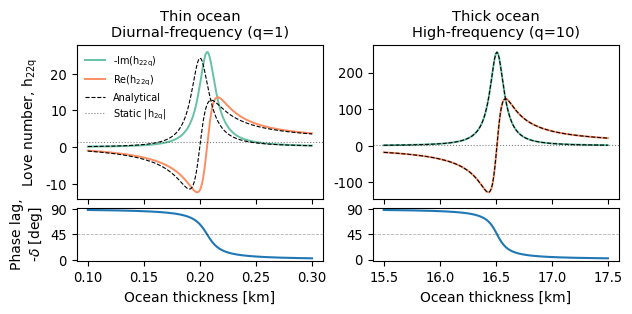

In [12]:
# Clear any existing figure output
sca(ax1); cla()
sca(ax2); cla()
sca(ax3); cla()
sca(ax4); cla()

# Calculate and plot figure 2
for q in [q1, q2]
    # Define ocean thickness range for each frequency
    if q == q1
        ho = range(100, stop=300, length=N) 
    elseif q == q2
        ho = range(15.5e3, stop=17.5e3, length=N) 
    end
    
    # Static numbers are needed to calculate the dynamic 
    # Love numbers. The static Love numbers have been pre-computed,
    # and are read from a file. The functions below are used to 
    # retrieve these Love numbers and their products using linear 
    # interpolation

    # Lookup static love numbers for a shell of thickness H_ice km,
    # shear modulus = 3.5 GPa and viscosity=10^18 Pa s
    β = beta_int(18, 3.5, H_ice, q, 1:1:nmax) # Get beta at all degrees
    ups = ups_int(18, 3.5, H_ice, q, 2) # Get upsilon at degree 2 only
    ht2 = ht_int(18, 3.5, H_ice, q, 2) # --> static tidal Love number
    hp2 = hp_int(18, 3.5, H_ice, q, 2) # --> static pressure Love number

    # In this figure, we only examine the eastward tidal component. (q>0)
    # This requires us to take the complex conjugagte of the static 
    # Love numbers
    β[:] .= conj.(β)
    ups = conj(ups)
    ht2 = conj(ht2)
    hp2 = conj(hp2)

    # Next, we will solve the Laplace Tidal Equations to find (1) the 
    # the velocity potential and stream function solution given by S, which 
    # will then be used to find (2) the dynamic Love number. This is a multi
    # step process using the module LTE_solver

    # Solve LTE for each ocean thickness
    for i in eachindex(ho)
        # Define the "moon". This is a struct to contain all the relevant 
        # geophysical parameters of the body that we are solving the 
        # LTE for.
        moon = Moon(rot_e, R_e, g_e, ho[i], alpha, nmax)   
        
        # We also assign the β parameter of the moon. This is necessary when
        # considering ocean loading and/or the overyling ice. 
        moon.βₙ[:] .= β[:] 

        # Next, we define the magnitude of the tidal forcing, which we write 
        # as υ*U^T. As we are only interested in the Love number, we set 
        # U^T = 1. Note that upsilon *must* be included here 
        fmag = 1.0*ups

        # Define the tidal forcing frequency. In our case, this is given by 
        # the integer q (defined in the first for-loop) multiplied the 
        # rotation rate of the moon. 
        ffreq = q*rot_e

        # Next we define another struct, called Forcing. This contains all 
        # the information about the forcing field. Below we define the forcing
        # field at freqeuncy ffreq, degree=2, order=2, and magnitude fmag
        forcing = Forcing(ffreq, 2, 2, fmag)

        # Now we define another struct, the LTE container. This contains all
        # information pertaining to the semi-analytical solution of the 
        # Laplace tidal equations. It essentially sets up the matrix problem
        # given by Eqs. A1 and A2: LTE*s = f, where LTE is the LTE matrix,
        # s is the solution vector containing the velocity potential and 
        # stream function at order-m, from degree=1 up to nmax, and f is the 
        # forcing vector.
        lte_container = LTE(moon, forcing, nmax)

        # Now call the function to solve the LTE probelm contained in the 
        # struct lte_container
        S = solve_LTE(lte_container) 

        # Here we get the h22 dynamic Love number using solution, S, computed 
        # above
        h22_num[i] = get_LN2mq(lte_container, S, 2, ht2, hp2, ups, moon.βₙ[2])

        # Alternatively, we can try and calculate h22 analytically using
        # the expressions given in the paper, using the wrapper function that 
        # is defined above, that requires only the body's geophysical parameters
        h22_analy[i] =  get_LN('h', 2, R_e, g_e, rot_e, H_ice, alpha, 3.5, ho[i]/1e3, q, 18);
    end
        

    # Plot solutions
    if q == q1 
        ax1.plot(ho./1e3, imag(h22_num[:]), ls="-", color=c1, lw=1.4, label="-Im(h\$_\\mathregular{22q}\$)")
        ax1.plot(ho./1e3, real(h22_num[:]), color=c2, ls="-", lw=1.4, label="Re(h\$_\\mathregular{22q}\$)")

        ax1.plot(ho./1e3, imag(h22_analy[:]), ls="--", color="k", lw=0.8, label="Analytical")
        ax1.plot(ho./1e3, real(h22_analy[:]), ls="--", color="k", lw=0.8)

        ax1.axhline(abs(ht2), color="k", ls=":", lw=0.8, alpha=0.5, label="Static |h\$_\\mathregular{2q}\$|")

        delta = atan.(imag.(h22_num[:]), real.(h22_num[:]))*180/pi *0.5
        ax3.plot(ho./1e3, delta)
        ax3.axhline(45.0, linestyle="--", alpha=0.3, lw=0.6, color="k")

    elseif q == q2
        ax2.plot(ho./1e3, imag(h22_num[:]), ls="-", color=c1, lw=1.4)
        ax2.plot(ho./1e3, real(h22_num[:]), color=c2, ls="-", lw=1.4)

        ax2.plot(ho./1e3, imag(h22_analy[:]), ls="--", color="k", lw=0.8)
        ax2.plot(ho./1e3, real(h22_analy[:]), ls="--", color="k", lw=0.8)

        ax2.axhline(abs(ht2), color="k", ls=":", lw=0.8, alpha=0.5)

        delta = atan.(imag.(h22_num[:]), real.(h22_num[:]))*180/pi *0.5
        ax4.plot(ho./1e3, delta)
        ax4.axhline(45.0, linestyle="--", alpha=0.3, lw=0.6, color="k")
    end
end

ax1.set_ylabel("Love number, h\$_\\mathregular{22q}\$")
ax1.set_xticklabels([])
ax2.set_xticklabels([])

ax1.set_title("Thin ocean\nDiurnal-frequency (q=1)")
ax2.set_title("Thick ocean\nHigh-frequency (q=10)")

ax3.set_ylabel("Phase lag,\n-\$\\delta\$ [deg]")
ax3.set_yticks([0, 45, 90])
ax4.set_yticks([0, 45, 90])

ax3.set_xlabel("Ocean thickness [km]")
ax4.set_xlabel("Ocean thickness [km]")

ax1.legend(frameon=false, prop=Dict("size" => 7))

savefig("figure2.pdf", bbox_inches="tight")
display(fig)

Now that the how-to has been demonstrated, we make use of the wrapper function get_LN where possible, which takes care of making all the structs for us, making the syntax much cleaner

# Figure 3

## Define parameter range

In [13]:
N = 1001 # Number of ocean thickness solutions per frequency
ho = 10 .^ (range(log10(1e3), stop=log10(149e3), length=N)); # Ocean thickness range
freqs = 1:1:30 # Only consider eastward tides in this plot (q>0).
alpha = 1e-6
visc = 13:1:15; # ice shell viscosity

## Define figure

In [14]:
# Define new figure
clf()
fig3, axes = subplots(ncols=2, nrows=3,sharex=true, constrained_layout=true, figsize=[fig_width,5.6])
ax1 = axes[1,1]
ax2 = axes[1,2]
ax3 = axes[2,1]
ax4 = axes[2,2]
ax5 = axes[3,1]
ax6 = axes[3,2];

secax1 = axes[1,1].twiny()
secax2 = axes[1,2].twiny()

fig3.subplots_adjust(bottom=0.2)
cbar_ax = fig3.add_axes([0.333333, 0.08, 0.33333333, 0.02]);

sys:1: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


## Calculate static and dynamic k_22q
This uses compact syntax, where the parameter range defined above is automatically 
expanded within the function itself

In [15]:
h_ice = (H_H2O_e .- ho)/1e3

# numerical = true uses the full numerical solution to the LTE, rather than the analyitcal approximation.
# By default, numerical=false. h2o_const is also used here, which stops the ice thickness and ocean thickness
# being independent parameters. In this case, the function calculates ocean thickness as h2o_const - h_ice.
# IMPORTANT: if h_ice is descending, then the Love numbers will be returned from small to large ocean thickness.
k22_dyn = get_LN('k', 2, R_e, g_e, rot_e, h_ice, alpha, 3.5, 1.0, freqs, visc, numerical=true, h2o_const=H_H2O_e/1e3);
k22_st = kt_int(visc, 3.5, h_ice, freqs, 2);

## Plot the static and dynamic k_22q

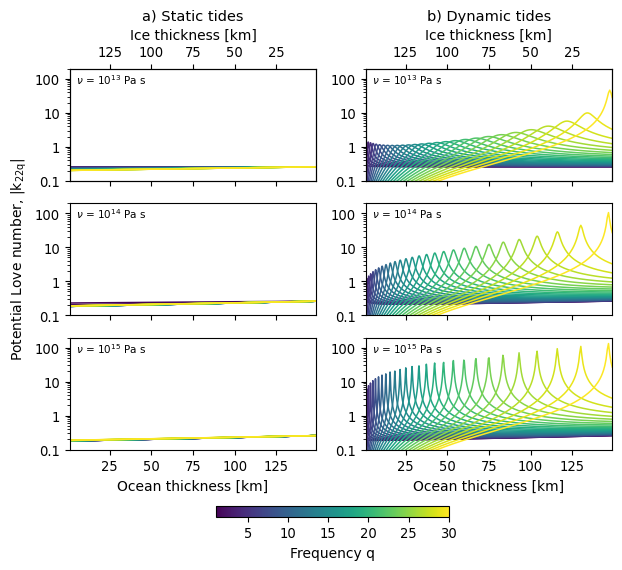

In [16]:
sca(ax1); cla()
sca(ax2); cla()
sca(ax3); cla()
sca(ax4); cla()
sca(ax5); cla()
sca(ax6); cla()
sca(secax1); cla()
sca(secax2); cla()
sca(cbar_ax); cla()

# Define colors for the plot
colors = range(0, 1, length=length(freqs))
cmap = PyPlot.cm.viridis

# Plot figure 3
for x in eachindex(visc)
    for j in eachindex(freqs)
        axes[x,1].semilogy(ho./1e3, abs.(k22_st[x, :, j]), ls="-", color=cmap(colors[j]), lw=1.1)
        axes[x,2].semilogy(ho./1e3, abs.(k22_dyn[x, :, j]), ls="-", color=cmap(colors[j]), lw=1.1)

    end

    axes[x, 1].set_ylim([0.1, 200])
    axes[x, 2].set_ylim([0.1, 200])
    axes[x, 1].set_xlim([1, 149])
    axes[x, 2].set_xlim([1, 149])

    axes[x,1].text(5, 70, "\$\\nu\$ = \$10^{\\mathregular{$(visc[x])}}\$ Pa s", size=7.5)
    axes[x,2].text(5, 70, "\$\\nu\$ = \$10^{\\mathregular{$(visc[x])}}\$ Pa s", size=7.5)

    tick_loc = axes[x, 1].get_yticks()
    axes[x,1].yaxis.set_major_locator(mpl.ticker.FixedLocator(tick_loc)) 
    axes[x,1].set_yticklabels(["x", "0.1", "1", "10", "100", "x", "x"])

    tick_loc = axes[x, 2].get_yticks()
    axes[x,2].yaxis.set_major_locator(mpl.ticker.FixedLocator(tick_loc)) 
    axes[x,2].set_yticklabels(["x", "0.1", "1", "10", "100", "x", "x"])
    
    
end

secax1.set_xlim([149, 1])
secax1.set_xlabel("Ice thickness [km]")

secax2.set_xlim([149, 1])
secax2.set_xlabel("Ice thickness [km]")

ax5.set_xlabel("Ocean thickness [km]")
ax6.set_xlabel("Ocean thickness [km]")

ax3.set_ylabel("Potential Love number, |k\$_\\mathregular{22q}\$|")

ax1.set_title("a) Static tides")
ax2.set_title("b) Dynamic tides")

norm = mpl.colors.Normalize(vmin=freqs[1], vmax=freqs[end])
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
cb = fig3.colorbar(sm, cax=cbar_ax, orientation="horizontal", aspect=20, label="Frequency q")
cb.set_ticks(5:5:30)

savefig("figure3.pdf", bbox_inches="tight")
display(fig3)


# Figure 5

## Define the figure

In [17]:
clf()
# PyPlot.close(fig3)

fig5, axes = subplots(ncols=3, nrows=2, sharex=true, sharey=true, constrained_layout=true, figsize=[fig_width,5.2])
ax1 = axes[1,1]
ax2 = axes[1,2]
ax3 = axes[1,3]
ax4 = axes[2,1]
ax5 = axes[2,2]
ax6 = axes[2,3];

secax1 = ax1.twiny()
secax2 = ax2.twiny()
secax3 = ax3.twiny();

sys:1: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


As we are interested in thicker oceans for this figure, we load static Love numbers defined for oceans 100-150km thick.

In [18]:
# Load precomputed static love number data, calculated using LNTools (Kamata et al., 2015).
dataFile = h5open("./data/static_ln_europa_thickocean.h5", "r")

# read Love number data
beta_data = read(dataFile["beta"])
ups_data  = read(dataFile["upsilon"])
hp_data  = read(dataFile["hp"])[:, :, :, :, 1, :] # h pressure Love number at surface 
ht_data  = read(dataFile["ht"])[:, :, :, :, 1, :] # h tidal Love number at surface
kp_data  = read(dataFile["kp"])[:, :, :, :, 1, :] # k pressure Love number at surface
kt_data  = read(dataFile["kt"])[:, :, :, :, 1, :] # k tidal Love number at surface
# Note, Love numbers at the ocean surface and bottom can be retrieved with 2 and 3


# read dimensions of data
h_ice = read(dataFile["ice thickness"])
visc_ice= vec(read(dataFile["ice viscosity"]) )
rig_ice = read(dataFile["ice rigidity"])
freqs = read(dataFile["frequencies"])
nmax = read(dataFile["nmax"])

close(dataFile);

indx = (visc_ice, rig_ice, h_ice, freqs, 1:nmax)

# Create linear interpolation object
beta_int = LinearInterpolation( indx, beta_data);
ups_int  = LinearInterpolation( indx, ups_data);
hp_int   = LinearInterpolation( indx, hp_data);
ht_int   = LinearInterpolation( indx, ht_data);
kp_int   = LinearInterpolation( indx, kp_data);
kt_int   = LinearInterpolation( indx, kt_data);

## Define function to calculate resonance width

In [19]:
function get_width(x, arr)
    function is_maxima(arr2)
        for j in 2:length(x)-1
            if arr2[j] > arr2[j+1] && arr2[j] > arr2[j-1]
                return true
            end
        end 
        return false
    end
    width = zeros(Float64, (size(arr)[2], 2))
    for i in 1:size(arr)[2]
        if is_maxima(arr[:,i])
            half_max = 0.5*maximum(arr[:,i])

            above_half = x[arr[:,i] .>= half_max]
            width[i,1] = above_half[1] 
            width[i, 2] = above_half[end]
        else
            width[i,1] = 0.0
            width[i,2] = 0.0
        end 
    end
    return width
end

get_width (generic function with 1 method)

## Define parameter range

In [20]:
N = 201

viscs = 13:1:15
alphas = 10 .^ (range(-5, -6, length=2))
mu = 10 .^ (range(-1, 1, length=N))
ho = 80e3:100:200e3
freqs = -25:-1:-30;

## Define solution arrays

In [21]:
width = zeros(Float64, (length(alphas), length(viscs), length(mu), length(freqs), 2));
hres  = zeros(Float64, (length(alphas), length(viscs), length(mu), length(freqs)));

## Calculate resonant ocean thickness
Below, we calculate the resonant thickness analytical. Note, though, that the problem is technically nonlinear because H^res depends on the ice shell thickness (through beta), which in turn depends on H^res if the entire water-ice layer is to remain constant. Below, we arrive we arrive at H^res via iteration.

In [22]:
for a in eachindex(alphas)
    alpha = alphas[a]

    for b in eachindex(viscs)
        ice_viscosity=viscs[b]
        
        for j in eachindex(mu)
            ice_mu = mu[j]
            h2 = zeros(Float64,(length(freqs), length(ho)))

            for k in eachindex(freqs)
                q = freqs[k]

                fmag = 1.0 # Forcing magnitude set to 1 as we are only interested in the Love numbers
                ffreq = q*rot_e

                forcing = Forcing(ffreq, 2, 2, fmag)
                residual = 10.0

                # Initial ice shell and ocean thickness guess
                H_ice = 10
                H_res = H_H2O_e/1e3 - H_ice

                # Iterate to find resonant ocean thickness:
                # H^res depends on the ice shell thickness, and the corresponding 
                # ice shell thickness depends on H_res if H^res + H_ice = H_H2O
                iter = 0
                while residual > 0.01
                    hres_guess = get_Hres(2, R_e, g_e, rot_e, H_ice, ice_mu, q, ice_viscosity)
                    
                    hice_guess = H_H2O_e - hres_guess

                    # Prevent the ice thickness from going out of bounds
                    hice_guess = max(hice_guess, 100)
                    hice_guess = min(hice_guess, 49e3)

                    residual = abs(H_ice - hice_guess/1e3)
                    H_ice = hice_guess/1e3
                    H_res = hres_guess/1e3

                    iter += 1

                    if iter >= 10000
                        println("Convergence failed! Setting resonant thickness to zero?")
                        H_res = 0.0
                        break
                    end

                end

                hres[a, b, j, k] = H_res
            end
            
        end
    end
end

## Calculate the h_22q Love number
To calculate how wide the resonance is, we calculate h_22q across the ocean thickness space and determine the full width at half maximum

In [23]:
# Set ice shell thickness array from ocean thickness array
h_ice = (H_H2O_e .- ho)./1e3
h_ice = collect(h_ice)
h_ice[h_ice .< 0.1] .= 0.1 # --> Prevent ice shell thickness from becoming negative

# Calculate h2 across ocean thickness, then get width of the resonance
# As h20_const is set, ocean thickness is automatically set to be h2o_const - h_ice
h2 = get_LN('h', 2, R_e, g_e, rot_e, h_ice, alphas, mu, 1.0, freqs, viscs, h2o_const=H_H2O_e/1e3);


Now calculate the resonance width

In [24]:
for a in eachindex(alphas)
    for b in eachindex(viscs)
        for j in eachindex(mu)
            width[a, b, j, :, :] .= get_width(ho/1e3, abs.(h2[b, a, :, j, :]))
        end
    end
end

## Plot results

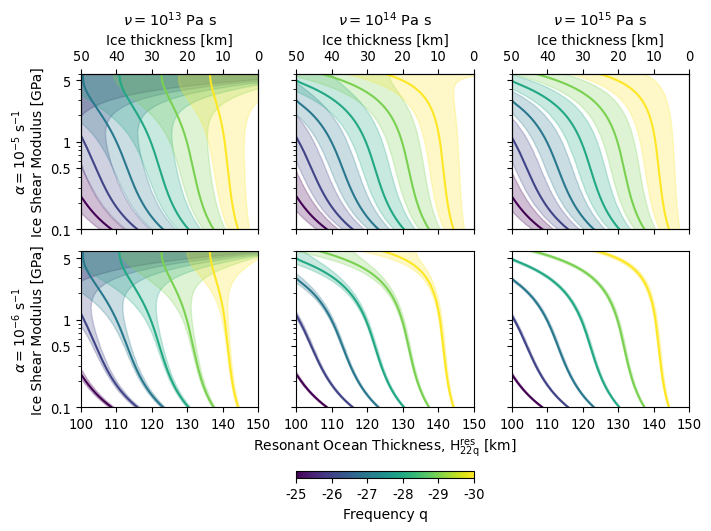

In [25]:
sca(ax1); cla()
sca(ax2); cla()
sca(ax3); cla()
sca(ax4); cla()
sca(ax5); cla()
sca(ax6); cla()
sca(secax1); cla()
sca(secax2); cla()
sca(secax3); cla()

# Define colors for the plot
colors = range(0, 1, length=length(freqs))
cmap = PyPlot.cm.viridis


for a in eachindex(alphas)
    for b in eachindex(viscs)
        for k in eachindex(freqs)

            axes[a,b].semilogy(hres[a,b,:,k], mu[:], color=cmap(colors[k]))

            axes[a,b].fill_betweenx(mu[:], width[a,b,:, k, 1], width[a,b,:, k, 2], color=cmap(colors[k]), alpha=0.25)

        end

        if a==1
            axes[a,b].set_title("\$\\nu\\mathregular{=10}^\\mathregular{ $(viscs[b]) }\$ Pa s")
        end
    end
end

ax1.set_xlim(100, 150)
ax1.set_ylim(0.1, 6.0)
ax1.set_xticks([100, 110, 120, 130, 140, 150])
ax5.set_xlabel("Resonant Ocean Thickness, \$\\mathregular{H}^{\\mathregular{res}}_{\\mathregular{22q}}\$ [km]")
ax1.set_ylabel("\$\\alpha\\mathregular{=10}^\\mathregular{-5}\$ s\$^\\mathregular{-1}\$\nIce Shear Modulus [GPa]")
ax4.set_ylabel("\$\\alpha\\mathregular{=10}^\\mathregular{-6}\$ s\$^\\mathregular{-1}\$\nIce Shear Modulus [GPa]")

for secax in [secax1 secax2 secax3]
    secax.set_xlim(50, 0)
    secax.set_xticks(50:-10:0)
    secax.set_xlabel("Ice thickness [km]")
end

tick_loc = [0.1, 0.5, 1, 5]
ax1.yaxis.set_major_locator(mpl.ticker.FixedLocator(tick_loc)) 
ax1.set_yticklabels(["0.1", "0.5", "1", "5"])

norm = mpl.colors.Normalize(vmin=freqs[end], vmax=freqs[1])
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)

cb = fig5.colorbar(sm, ax=ax5, orientation="horizontal", aspect=20, label="Frequency q")
cb.set_ticks(-25:-1:-30)
cb.set_ticklabels(["-30","-29","-28","-27","-26", "-25"])

savefig("figure5.pdf", bbox_inches="tight")
display(fig5)

Note that the highest frequency resonance is unphysical, as the ocean is thicker than the h20 layer. However, it nicely illustrates that the resonant thickness is mostly independent of shear modulus when the ice is thin (H_ice is never allowed to be less than 100m).

# Figure 6

## Define figure

In [26]:
fig6, (ax1, ax2) = subplots(ncols=2, figsize=(fig_width, 3.23));

## Define parameter range

In [27]:
freqs = -26:-0.01:-30
alpha = 1e-5
nmax = 2
ice_viscosity = 18 # Elastic ice shell
ho = 100:0.1:150
fmag = 1.0 # Forcing magnitude set to 1 as we are only interested in the Love numbers

hs = [20, 15, 10]
rigs = [3 4 6; 1 1.333333 2; 0.3 0.4 0.6];

## Calculate and plot solution

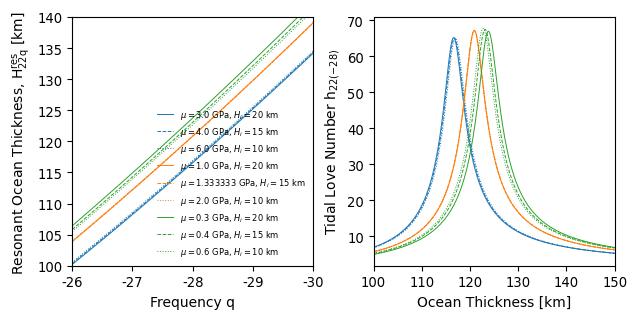

In [28]:
sca(ax1); cla()
sca(ax2); cla()

ls = Dict(20 => "-", 15 => "--", 10 => ":")
color = Dict(1 => "C0", 2 => "C1", 3 => "C2")


hres  = zeros(Float64, (3, length(freqs)));
h22  = zeros(Float64, (length(ho)) );
# Loop over different sets of \mu * H_ice = constant
i = 1
for i in 1:1:3
     for (rig, h) in zip(rigs[i,:], hs)
          moon = Moon(rot_e, R_e, g_e, 100e3, alpha, nmax)   # Ocean thickness doesn't matter here

          for k in eachindex(freqs)
               q = freqs[k]

               hres[i, k] = get_Hres(2, R_e, g_e, rot_e, h, rig, q, ice_viscosity)
          end

          q = -28
          h22[:] .= abs.( get_LN('h', 2, R_e, g_e, rot_e, h, alpha, rig, ho, q, ice_viscosity) )
          
          ax1.plot(freqs, hres[i,:]/1e3, color=color[i], ls=ls[h], lw=0.7, label="\$\\mu = $rig\$ GPa, \$H_i = $h\$ km")
          ax2.plot(ho, h22, color=color[i], ls=ls[h], lw=0.7)
     end
end

ax1.invert_xaxis()

ax1.set_xlim([-26,-30])
ax2.set_xlim([100,150])
ax1.set_ylim([100,140])

ax1.set_xlabel("Frequency q")
ax1.set_ylabel("Resonant Ocean Thickness, H\$^\\mathregular{res}_\\mathregular{22q}\$ [km] ")

ax2.set_ylabel("Tidal Love Number h\$_\\mathregular{22(-28)}\$")
ax2.set_xlabel("Ocean Thickness [km]")

ax1.legend(frameon=false, prop=Dict("size" => 6))
subplots_adjust(wspace=0.25)

savefig("figure6.pdf", bbox_inches="tight")
display(fig6)

# Figure 7

## Define figure

In [29]:
fig7, axes = plt.subplots(ncols=3, nrows=2, constrained_layout=true, sharex=true, sharey=true, figsize=(fig_width, 5))

ax1 = axes[1,1]
ax2 = axes[1,2]
ax3 = axes[1,3]
ax4 = axes[2,1]
ax5 = axes[2,2]
ax6 = axes[2,3];

## Define parameter range

In [30]:
N = 501
hi = 10:10:30
ho = 100:0.1:150
alphas = [1e-5, 1e-6]
rigs = 10 .^ (range(-1, 1, length=N))
freqs = -1:-1:-35
ice_viscosity = 16;

## Load relevant static Love numbers

In [31]:
# Load precomputed static love number data, calculated using LNTools (Kamata et al., 2015).
dataFile = h5open("./data/static_ln_europa_misfit.h5", "r")

# read Love number data
beta_data = read(dataFile["beta"])
ups_data  = read(dataFile["upsilon"])
hp_data  = read(dataFile["hp"])[:, :, :, :, 1, :] # h pressure Love number at surface 
ht_data  = read(dataFile["ht"])[:, :, :, :, 1, :] # h tidal Love number at surface
kp_data  = read(dataFile["kp"])[:, :, :, :, 1, :] # k pressure Love number at surface
kt_data  = read(dataFile["kt"])[:, :, :, :, 1, :] # k tidal Love number at surface
# Note, Love numbers at the ocean surface and bottom can be retrieved with 2 and 3


# read dimensions of data
h_ice = read(dataFile["ice thickness"])
visc_ice= vec(read(dataFile["ice viscosity"]) )
rig_ice = read(dataFile["ice rigidity"])
freqs = read(dataFile["frequencies"])
nmax = read(dataFile["nmax"])

close(dataFile)

indx = (visc_ice, rig_ice, h_ice, freqs, 1:1:nmax)

# Create linear interpolation functions
beta_int = LinearInterpolation( indx, beta_data, extrapolation_bc=Line() );
ups_int  = LinearInterpolation( indx, ups_data, extrapolation_bc=Line() );
hp_int   = LinearInterpolation( indx, hp_data, extrapolation_bc=Line() );
ht_int   = LinearInterpolation( indx, ht_data, extrapolation_bc=Line() );
kp_int   = LinearInterpolation( indx, kp_data, extrapolation_bc=Line() );
kt_int   = LinearInterpolation( indx, kt_data, extrapolation_bc=Line() );

## Calculate reference model Love numbers

In [32]:
ho_ref = 130
rig_ref = 3.5
hi_ref = 20
visc_ref = 16
alpha = 1e-6

h2_ref_m0 = get_LN('h', 0, R_e, g_e, rot_e, hi_ref, alpha, rig_ref, ho_ref, freqs, visc_ref);

h2_ref_m2 = get_LN('h', 2, R_e, g_e, rot_e, hi_ref, alpha, rig_ref, ho_ref, freqs, visc_ref);


## Calculate Love numbers over parameter space

In [33]:
h2_all_m2 = get_LN('h', 2, R_e, g_e, rot_e, hi, alphas, rigs, ho, freqs, ice_viscosity);
h2_all_m0 = get_LN('h', 0, R_e, g_e, rot_e, hi, alphas, rigs, ho, freqs, ice_viscosity);

## Calculate misfit and plot 

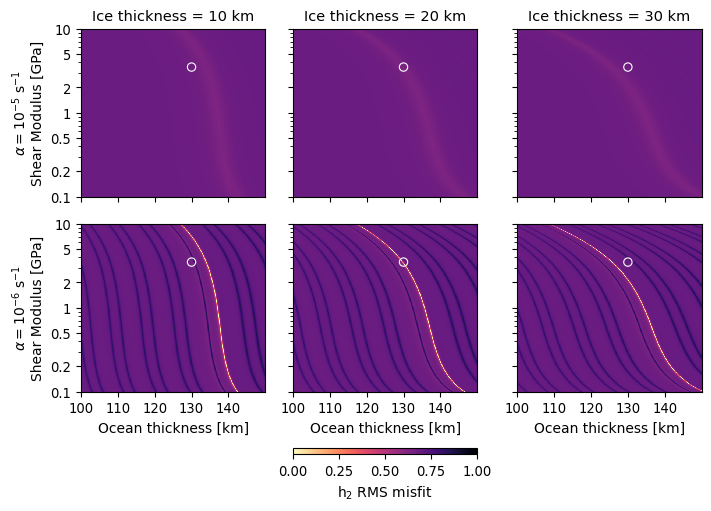

In [34]:
sca(ax1); cla()
sca(ax2); cla()
sca(ax3); cla()
sca(ax4); cla()
sca(ax5); cla()
sca(ax6); cla()

for j in eachindex(hi)
    h = hi[j]
    for x in eachindex(alphas)
        diff = h2_ref_m2[newaxis, :, newaxis] .- h2_all_m2[x, j, :, :, :]
        soln = diff.^2

        diff = h2_ref_m0[newaxis, :, newaxis] .- h2_all_m0[x, j, :, :, :]
        soln = sum(abs.(soln .+ diff.^2), dims=2)[:, 1, :]

        misfit = sqrt.(soln) ./ (4*length(freqs))
        
        c = axes[x, j].pcolormesh(ho, rigs, log10.(misfit), cmap=PyPlot.cm.magma_r, shading="nearest", rasterized=true, vmin=0, vmax=1)
        axes[x, j].set_yscale("log")

        axes[x, j].scatter(ho_ref, rig_ref, facecolors="none", edgecolors="w", linewidth=0.8)
    end
    axes[1, j].set_title("Ice thickness = $h km")
end


axes[1,1].set_xticks([100, 110, 120, 130, 140])
axes[1,1].set_ylabel("\$\\alpha\\mathregular{=10}^\\mathregular{-5}\$ s\$^\\mathregular{-1}\$\nShear Modulus [GPa]")
axes[2,1].set_ylabel("\$\\alpha\\mathregular{=10}^\\mathregular{-6}\$ s\$^\\mathregular{-1}\$\nShear Modulus [GPa]")

axes[2,1].set_xlabel("Ocean thickness [km]")
axes[2,2].set_xlabel("Ocean thickness [km]")
axes[2,3].set_xlabel("Ocean thickness [km]")

norm = mpl.colors.Normalize(vmin=0, vmax=1)
sm = mpl.cm.ScalarMappable(cmap=PyPlot.cm.magma_r, norm=norm)
cb = fig7.colorbar(sm, ax=ax5, orientation="horizontal", aspect=20, label="h\$_\\mathregular{2}\$ RMS misfit")

tick_loc = [0.1, 0.2, 0.5, 1, 2, 5, 10]
ax1.yaxis.set_major_locator(mpl.ticker.FixedLocator(tick_loc)) 
ax1.set_yticklabels(["0.1", "0.2", "0.5", "1", "2", "5", "10"])

savefig("figure7.pdf", bbox_inches="tight")
display(fig7)

# Figure 8

## Define figure

In [35]:
fsize=1.3
fig8, axes = subplots(ncols=2, nrows=2, sharex=true, constrained_layout=true, figsize=(fig_width,6.46))

ax1 = axes[1,1]
ax2 = axes[1,2]
ax3 = axes[2,1]
ax4 = axes[2,2];

fig8.subplots_adjust(bottom=0.2)
cbar_ax = fig8.add_axes([0.333333, 0.08, 0.33333333, 0.02]);

sys:1: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


## Define parameter range

In [36]:
ho = 100:0.01:140
hi = H_H2O_e/1e3 .- ho
alphas = [1e-6, 1e-10]
rigs = 3.5
freqs_w = -1:-1:-30
freqs_e = 1:1:30
nmax = 2
ice_viscosity = 16:-2:14;

## Calculate the dynamic tidal Love numbers

In [37]:
h2_m2_e = get_LN('h', 2, R_e, g_e, rot_e, hi, alphas, rigs, ho, freqs_e, ice_viscosity, h2o_const=H_H2O_e/1e3);
h2_m2_w = get_LN('h', 2, R_e, g_e, rot_e, hi, alphas, rigs, ho, freqs_w, ice_viscosity, h2o_const=H_H2O_e/1e3);
h2_m0 = get_LN('h', 0, R_e, g_e, rot_e, hi, alphas, rigs, ho, freqs_e, ice_viscosity, h2o_const=H_H2O_e/1e3);

## Load precomputed tidal potential coefficients
Note that these coefficients are as defined in Hay and Matsuyama (2019b), and are 4pi normalized.

In [38]:
F = h5open("./data/galilean_tide_coeffs.h5", "r")

freqs_data  = read(F["europa"]["io"]["frequency q"])
Unmq = read(F["europa"]["io"]["tide coeffs"]) + read(F["europa"]["eccentricity"]["tide coeffs"])
Unmq *= 0.5 # Must halve due to fourier transform

close(F)

Get the tidal potential coefficients over the correct frequency range

In [39]:
# Note that the tidal coefficients have the opposite
# sign convetion for frequency, so we multiply by -1
indx1 = argmin(abs.(freqs_data .- -freqs_e[1]))
indx2 = argmin(abs.(freqs_data .- -freqs_e[end]))
Unmq_e = Unmq[:, indx1:-1:indx2]

U22eq = Unmq_e[5,:] .+ Unmq_e[12,:] # a22q + b22q
U20q  = Unmq_e[1,:]                 # a20q

indx1 = argmin(abs.(freqs_data .- -freqs_w[1]))
indx2 = argmin(abs.(freqs_data .- -freqs_w[end]))
Unmq_w = Unmq[:, indx1:1:indx2]

U22wq = Unmq_w[5,:] .+ Unmq_w[12,:] # a22q + b22q

# Add single dimensions to allow for broadcasting
U22eq = reshape(U22eq,(1, 1, 1, length(U22eq)))
U22wq = reshape(U22wq,(1, 1, 1, length(U22wq)))
U20q = reshape(U20q,(1, 1, 1, length(U20q)));

## Calculate the radial deformation and acceleration 

In [40]:
# Get 4pi normalized associated Legendre Polynomials
colat = pi/2
P20 = 0.5 * (3cos(colat)^2 - 1) * sqrt((2*2 + 1) * factorial(2) / factorial(2))
P22 = 3 * (1 - cos(colat)^2) * sqrt((2*2 + 1) * factorial(0) / factorial(4)) 

# Get deformation from each tidal component
eta_22w = h2_m2_w .* U22wq ./ g_e;
eta_22e = h2_m2_e .* U22eq ./ g_e;
eta_20 = h2_m0 .* U20q ./ g_e;

qs = reshape(freqs_e, (1, 1, 1, length(freqs_e)))

# Calculate deformation in metres and acceleration in mGal
eta = abs.(P22 .* (eta_22e .+ eta_22w) .+ 2*P20 .* eta_20);
gals = eta .* (qs .* rot_e).^2 .* METRE_TO_CM * GAL_TO_MGAL;

## Plot solutions

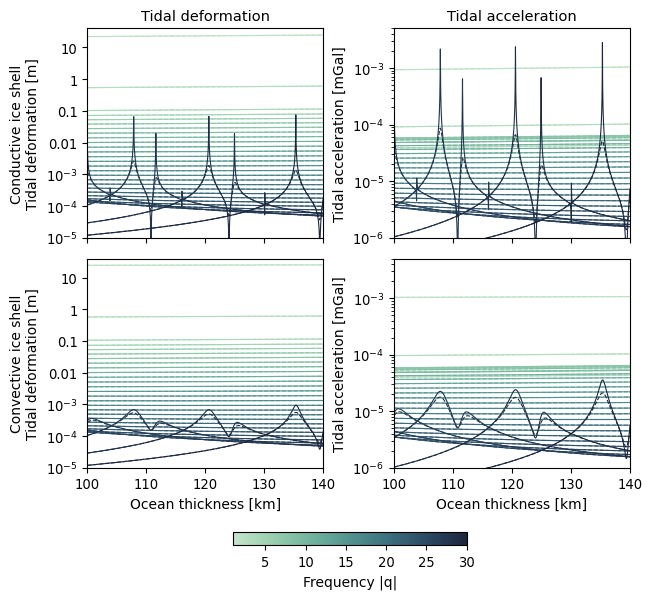

In [41]:
sca(ax1); cla()
sca(ax2); cla()
sca(ax3); cla()
sca(ax4); cla()
sca(cbar_ax); cla()

cmap = sns.cubehelix_palette(rot=-.4, as_cmap=true)

norm = mpl.colors.Normalize(vmin=freqs_e[1], vmax=freqs_e[end])
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)

for i in eachindex(ice_viscosity)
    for q in freqs_e
        # Use this if statement to isolate different frequencies
        if q >= 1
            axes[i,1].semilogy(ho, eta[i,1,:,q], "--", zorder=q, lw=0.8, color=cmap(q/length(freqs_e)))
            axes[i,1].semilogy(ho, eta[i,2,:,q], "-", zorder=q, lw=0.8,color=cmap(q/length(freqs_e)))

            axes[i,2].semilogy(ho, gals[i,1,:,q], "--", zorder=q, lw=0.8, color=cmap(q/length(freqs_e)))
            axes[i,2].semilogy(ho, gals[i,2,:,q], "-", zorder=q, lw=0.8,color=cmap(q/length(freqs_e)))
    
        end
    end    
end

for ax in [ax1, ax3]
    ax.set_xlim([100, 140])
    ax.set_ylim([1e-5, 40])
end

for ax in [ax2, ax4]
    ax.set_xlim([100, 140])
    ax.set_ylim([1e-6, 5e-3])
end

ax1.set_ylabel("Conductive ice shell\nTidal deformation [m]")
ax2.set_ylabel("Tidal acceleration [mGal]")

ax3.set_ylabel("Convective ice shell\nTidal deformation [m]")
ax4.set_ylabel("Tidal acceleration [mGal]")

ax1.set_title("Tidal deformation")
ax2.set_title("Tidal acceleration")

ax3.set_xlabel("Ocean thickness [km]")
ax4.set_xlabel("Ocean thickness [km]")

for ax in [ax1 ax3]
    tick_loc = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
    ax.yaxis.set_major_locator(mpl.ticker.FixedLocator(tick_loc)) 
    ax.set_yticklabels(["10\$^\\mathregular{-5}\$",
                        "10\$^\\mathregular{-4}\$",
                        "10\$^\\mathregular{-3}\$",
                        "0.01", "0.1","1", "10"])
end
for ax in [ax2 ax4]
    tick_loc = [1e-6, 1e-5, 1e-4, 1e-3]
    ax.yaxis.set_major_locator(mpl.ticker.FixedLocator(tick_loc)) 
    ax.set_yticklabels(["10\$^\\mathregular{-6}\$",
                        "10\$^\\mathregular{-5}\$",
                        "10\$^\\mathregular{-4}\$",
                        "10\$^\\mathregular{-3}\$"])
end

for ax in [ax1 ax2 ax3 ax4]
    # ax.set_zorder(1e6)
    # ax.set_axisbelow(false)
    # println(ax.spines[:items])
    for (key, spine) in ax.spines  #ax.spines is a dictionary
        spine.set_zorder(10000)
        # println(key, ' ', spine)
    end
end

cb = fig8.colorbar(sm, cax=cbar_ax, orientation="horizontal", aspect=20, label="Frequency |q|")
cb.set_ticks(5:5:30)

subplots_adjust(wspace=0.3, hspace=0.1)

savefig("figure8.pdf", bbox_inches="tight")
display(fig8)


# Figure 9 - Europa

## Define figure

In [42]:
fig9, axes9 = subplots(nrows=2, ncols=2, sharex=true, figsize=[fig_width,3.84], gridspec_kw=Dict("height_ratios"=>[1, 0.3]))

ax1_9 = axes9[1,1]
ax2_9 = axes9[2,1]
ax3_9 = axes9[1,2]
ax4_9 = axes9[2,2]

PyObject <AxesSubplot:>

Load the relevant set of static Love numbers and define their interpolating functions

In [43]:
# Load precomputed static love number data, calculated using LNTools (Kamata et al., 2015).
dataFile = h5open("./data/static_ln_europa_all.h5", "r")

# read Love number data
beta_data = read(dataFile["beta"])
ups_data  = read(dataFile["upsilon"])
hp_data  = read(dataFile["hp"])[:, :, :, :, 1, :] # h pressure Love number at surface 
ht_data  = read(dataFile["ht"])[:, :, :, :, 1, :] # h tidal Love number at surface
kp_data  = read(dataFile["kp"])[:, :, :, :, 1, :] # k pressure Love number at surface
kt_data  = read(dataFile["kt"])[:, :, :, :, 1, :] # k tidal Love number at surface
# Note, Love numbers at the ocean surface and bottom can be retrieved with 2 and 3


# read dimensions of data
h_ice = read(dataFile["ice thickness"])
visc_ice= vec(read(dataFile["ice viscosity"]) )
rig_ice = read(dataFile["ice rigidity"])
freqs = read(dataFile["frequencies"])
nmax = read(dataFile["nmax"])

close(dataFile)

indx = (visc_ice, rig_ice, h_ice, freqs, 1:1:nmax)

# Create linear interpolation object
beta_int = LinearInterpolation( indx, beta_data, extrapolation_bc=Line() );
ups_int  = LinearInterpolation( indx, ups_data, extrapolation_bc=Line() );
hp_int   = LinearInterpolation( indx, hp_data, extrapolation_bc=Line() );
ht_int   = LinearInterpolation( indx, ht_data, extrapolation_bc=Line() );
kp_int   = LinearInterpolation( indx, kp_data, extrapolation_bc=Line() );
kt_int   = LinearInterpolation( indx, kt_data, extrapolation_bc=Line() );

## Define parameters and calculate dynamic and static Love numbers

In [44]:
# Define reference parameters
ho_ref = 130
rig_ref = 3.5
hi_ref = 20
visc_ref = 18
alpha = 1e-6

# Consider both westward and eastward tides
freqs_w = -1:-0.1:-8
freqs_e = 1:0.1:8

# Eastward k_22q
k22_ref_m2_e = get_LN('k', 2, R_e, g_e, rot_e, 
                 hi_ref, alpha, 
                 rig_ref, ho_ref, 
                 freqs_e, visc_ref);

# westward k_22q
k22_ref_m2_w = get_LN('k', 2, R_e, g_e, rot_e, 
                    hi_ref, alpha, 
                    rig_ref, ho_ref, 
                    freqs_w, visc_ref);

k2_static = kt_int(visc_ref, rig_ref, hi_ref, freqs_e, 2);

# Deviation from the static value due to ocean dynamics
diff_e = (k22_ref_m2_e .- k2_static) ./ k2_static * 100;
diff_w = (k22_ref_m2_w .- k2_static) ./ k2_static * 100;  

## Plot Love numbers

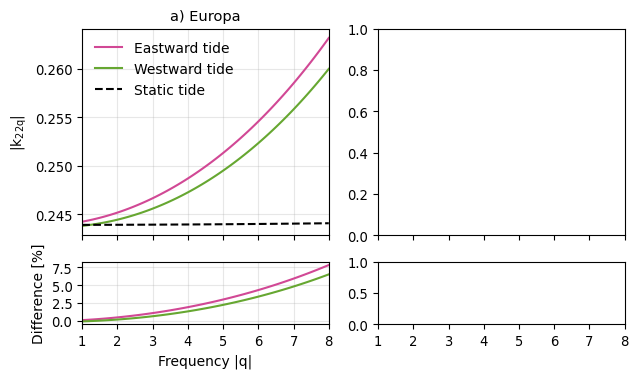

In [45]:
sca(ax1_9); cla()
sca(ax2_9); cla()

# Define line colours
cm = get_cmap(:PiYG)
c1 = cm(0.15)
c2 = cm(0.85)

ax1_9.plot(freqs_e, abs.(k22_ref_m2_e), label="Eastward tide", color=c1)
ax1_9.plot(freqs_e, abs.(k22_ref_m2_w), label="Westward tide", color=c2)
ax1_9.plot(freqs_e, abs.(k2_static), "k--", label="Static tide")

ax2_9.plot(freqs_e, real.(diff_e), color=c1)
ax2_9.plot(freqs_e, real.(diff_w), color=c2)

ax1_9.legend(frameon=false)

ax1_9.set_ylabel("|k\$_\\mathregular{22q}\$|")
ax2_9.set_ylabel("Difference [%]")
ax2_9.set_xlabel("Frequency |q|")

ax1_9.grid(which="both", alpha=0.3)
ax2_9.grid(which="both", alpha=0.3)

ax1_9.set_xlim([1, 8])
ax1_9.set_title("a) Europa")

ax2_9.set_yticks([0, 2.5, 5, 7.5])
ax2_9.set_xticks(1:8)

display(fig9)

# Don't forget about Ganymede!


In [46]:
# Constants for Ganymede
R_g = 2638e3       # Radius
g_g = 1.432         # Gravity
rot_g = 1.025e-5    # Rotation rate

H_H2O_g = 250e3;    # H2O layer thickness

In [47]:
# Load precomputed static love number data, calculated using LNTools (Kamata et al., 2015).
dataFile = h5open("./data/static_ln_ganymede_all.h5", "r")

# read Love number data
beta_data = read(dataFile["beta"])
ups_data  = read(dataFile["upsilon"])
hp_data  = read(dataFile["hp"])[:, :, :, :, 1, :] # h pressure Love number at surface 
ht_data  = read(dataFile["ht"])[:, :, :, :, 1, :] # h tidal Love number at surface
kp_data  = read(dataFile["kp"])[:, :, :, :, 1, :] # k pressure Love number at surface
kt_data  = read(dataFile["kt"])[:, :, :, :, 1, :] # k tidal Love number at surface
# Note, Love numbers at the ocean surface and bottom can be retrieved with 2 and 3


# read dimensions of data
h_ice = read(dataFile["ice thickness"])
visc_ice= vec(read(dataFile["ice viscosity"]) )
rig_ice = vec(read(dataFile["ice rigidity"]))
freqs = read(dataFile["frequencies"])
nmax = read(dataFile["nmax"])

close(dataFile)

indx = (visc_ice, rig_ice, h_ice, freqs, 1:1:nmax)

# Create linear interpolation object
beta_int = LinearInterpolation( indx, beta_data, extrapolation_bc=Line() );
ups_int  = LinearInterpolation( indx, ups_data, extrapolation_bc=Line() );
hp_int   = LinearInterpolation( indx, hp_data, extrapolation_bc=Line() );
ht_int   = LinearInterpolation( indx, ht_data, extrapolation_bc=Line() );
kp_int   = LinearInterpolation( indx, kp_data, extrapolation_bc=Line() );
kt_int   = LinearInterpolation( indx, kt_data, extrapolation_bc=Line() );

# Figure 9 - Ganymede

## Define parameters and calculate dynamic and static Love numbers

In [48]:
# Define reference parameters
ho_ref = 150
rig_ref = 3.5
hi_ref = 100
visc_ref = 18
alpha = 1e-6

# Consider both westward and eastward tides
freqs_w = -1:-0.1:-8
freqs_e = 1:0.1:8

# Eastward k_22q
k22_ref_m2_e = get_LN('k', 2, R_g, g_g, rot_g, 
                 hi_ref, alpha, 
                 rig_ref, ho_ref, 
                 freqs_e, visc_ref);

# westward k_22q
k22_ref_m2_w = get_LN('k', 2, R_g, g_g, rot_g, 
                    hi_ref, alpha, 
                    rig_ref, ho_ref, 
                    freqs_w, visc_ref);

k2_static = kt_int(visc_ref, rig_ref, hi_ref, freqs_e, 2);

# Deviation from the static value due to ocean dynamics
diff_e = (k22_ref_m2_e .- k2_static) ./ k2_static * 100;
diff_w = (k22_ref_m2_w .- k2_static) ./ k2_static * 100;  

## Plot Love numbers

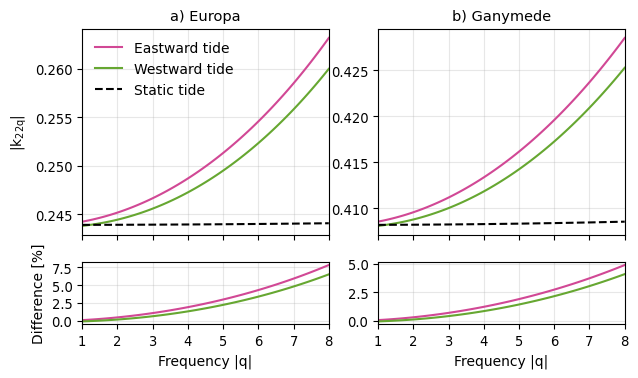

In [49]:
sca(ax3_9); cla()
sca(ax4_9); cla()

# Define line colours
cm = get_cmap(:PiYG)
c1 = cm(0.15)
c2 = cm(0.85)

ax3_9.plot(freqs_e, abs.(k22_ref_m2_e), label="Eastward tide", color=c1)
ax3_9.plot(freqs_e, abs.(k22_ref_m2_w), label="Westward tide", color=c2)
ax3_9.plot(freqs_e, abs.(k2_static), "k--", label="Static tide")

ax4_9.plot(freqs_e, real.(diff_e), color=c1)
ax4_9.plot(freqs_e, real.(diff_w), color=c2)

ax4_9.set_xlabel("Frequency |q|")

ax3_9.grid(which="both", alpha=0.3)
ax4_9.grid(which="both", alpha=0.3)

ax4_9.set_xlim([1, 8])
ax4_9.set_yticks([0, 2.5, 5])
ax4_9.set_xticks(1:8)

ax3_9.set_title("b) Ganymede")

savefig("figure9.pdf")
display(fig9)

# Figure 4

## Define figure

In [50]:
# Define new figure
# clf()
fig4, axes = subplots(ncols=2, nrows=3, sharex=true, constrained_layout=true, figsize=[fig_width,5.6])
ax1 = axes[1,1]
ax2 = axes[1,2]
ax3 = axes[2,1]
ax4 = axes[2,2]
ax5 = axes[3,1]
ax6 = axes[3,2];

secax1 = axes[1,1].twiny()
secax2 = axes[1,2].twiny()

fig4.subplots_adjust(bottom=0.2)
cbar_ax = fig4.add_axes([0.333333, 0.08, 0.33333333, 0.02]);

sys:1: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


## Define parameter range

In [51]:
N = 1001 # Number of ocean thickness solutions per frequency
ho = 10 .^ (range(log10(1.5e3), stop=log10(249e3), length=N)); # Ocean thickness range
freqs = 1:1:44 # Only consider eastward tides in this plot (q>0).
alpha = 1e-6
visc = 13:1:15; # ice shell viscosity

## Calculate static and dynamic k_22q
This uses compact syntax, where the parameter range defined above is automatically 
expanded within the function itself

In [52]:
h_ice = (H_H2O_g .- ho)/1e3

# numerical = true uses the full numerical solution to the LTE, rather than the analyitcal approximation.
# By default, numerical=false. h2o_const is also used here, which stops the ice thickness and ocean thickness
# being independent parameters. In this case, the function calculates ocean thickness as h2o_const - h_ice.
# IMPORTANT: if h_ice is descending, then the Love numbers will be returned from small to large ocean thickness.
k22_dyn = get_LN('k', 2, R_g, g_g, rot_g, h_ice, alpha, 3.5, 1.0, freqs, visc, numerical=true, h2o_const=H_H2O_g/1e3);
k22_st = kt_int(visc, 3.5, h_ice, freqs, 2);

## Plot the static and dynamic k_22q

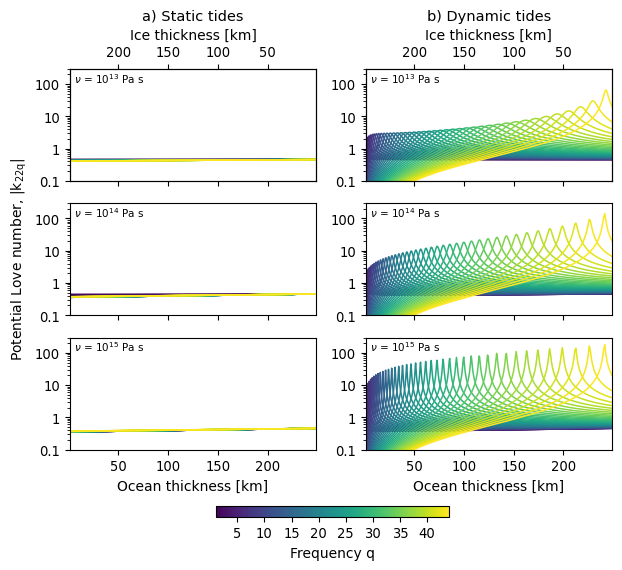

In [53]:
sca(ax1); cla()
sca(ax2); cla()
sca(ax3); cla()
sca(ax4); cla()
sca(ax5); cla()
sca(ax6); cla()
sca(secax1); cla()
sca(secax2); cla()
sca(cbar_ax); cla()

# Define colors for the plot
colors = range(0, 1, length=length(freqs))
cmap = PyPlot.cm.viridis

# Plot figure 3
for x in eachindex(visc)
    for j in eachindex(freqs)
        axes[x,1].semilogy(ho./1e3, abs.(k22_st[x, :, j]), ls="-", color=cmap(colors[j]), lw=1.1)
        axes[x,2].semilogy(ho./1e3, abs.(k22_dyn[x, :, j]), ls="-", color=cmap(colors[j]), lw=1.1)

    end

    axes[x, 1].set_ylim([0.1, 300])
    axes[x, 2].set_ylim([0.1, 300])
    axes[x, 1].set_xlim([1, 249])
    axes[x, 2].set_xlim([1, 249])

    axes[x,1].text(5, 110, "\$\\nu\$ = 10\$^{\\mathregular{$(visc[x])}}\$ Pa s", size=7.5)
    axes[x,2].text(5, 110, "\$\\nu\$ = 10\$^{\\mathregular{$(visc[x])}}\$ Pa s", size=7.5)

    tick_loc = axes[x, 1].get_yticks()
    axes[x,1].yaxis.set_major_locator(mpl.ticker.FixedLocator(tick_loc)) 
    axes[x,1].set_yticklabels(["x", "0.1", "1", "10", "100", "x", "x"])

    tick_loc = axes[x, 2].get_yticks()
    axes[x,2].yaxis.set_major_locator(mpl.ticker.FixedLocator(tick_loc)) 
    axes[x,2].set_yticklabels(["x", "0.1", "1", "10", "100", "x", "x"])
end

secax1.set_xlim([249, 1])
secax1.set_xlabel("Ice thickness [km]")

secax2.set_xlim([249, 1])
secax2.set_xlabel("Ice thickness [km]")

ax5.set_xlabel("Ocean thickness [km]")
ax6.set_xlabel("Ocean thickness [km]")

ax3.set_ylabel("Potential Love number, |k\$_\\mathregular{22q}\$|")

ax1.set_title("a) Static tides")
ax2.set_title("b) Dynamic tides")

norm = mpl.colors.Normalize(vmin=freqs[1], vmax=freqs[end])
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
cb = fig4.colorbar(sm, cax=cbar_ax, orientation="horizontal", aspect=20, shrink=0.1,label="Frequency q")
cb.set_ticks(5:5:45)
savefig("figure4.pdf", bbox_inches="tight")
display(fig4)